# TensorFlow Transformer - CV 0.131 LB 0.112
The transformer in this notebook has an **amazing CV 0.131** on `u_out=0`. When we submit 1 fold, it achieves LB 0.131. When we submit (the median of) 11 folds, it achieves LB 0.115, and when we submit 32 folds, it achieves an **amazing gold medal LB 0.112**! It trains with three targets `pressure`, `pressure.diff()`, and `pressure.cumsum()` but we only submit the predictions for `pressure` to Kaggle.

I'm very proud of this transformer. In Kaggle's Vent Comp, there are many pubic notebooks demonstrating how to build RNNs but there are not public notebooks about transformers. I needed to design this network and tune this network by myself. I am very happy with the results.

My teammate @drhabib , @mmotoki , @lihuajing , @yamsam gave me many helpful suggestions to improve CV from 0.170 to 0.130. Thanks teammates!

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

VER = 84
FIRST_FOLD_ONLY = True
TRAIN_MODEL = False

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

import pandas as pd, numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error

# Load Data and Feature Engineer
We will use the features from [DLastStark's][2] great notebook [here][1]. Most likely if we remove and/or add features we can improve this transformers CV LB.

[1]: https://www.kaggle.com/dlaststark/gb-vpp-pulp-fiction
[2]: https://www.kaggle.com/dlaststark

In [3]:
train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
test = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')

In [4]:
def add_features(df):
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    print("Step-1...Completed")
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    print("Step-2...Completed")
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_in__mean'] = df.groupby(['breath_id'])['u_in'].transform('mean')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']

    print("Step-3...Completed")
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    print("Step-4...Completed")
    
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['breath_id__u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['breath_id__u_in_lag'] = df['breath_id__u_in_lag'] * df['breath_id_lagsame']
    df['breath_id__u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['breath_id__u_in_lag2'] = df['breath_id__u_in_lag2'] * df['breath_id_lag2same']
    print("Step-5...Completed")
    
    df['time_step_diff'] = df.groupby('breath_id')['time_step'].diff().fillna(0)
    df['ewm_u_in_mean'] = (df\
                           .groupby('breath_id')['u_in']\
                           .ewm(halflife=9)\
                           .mean()\
                           .reset_index(level=0,drop=True))
    df[["15_in_sum","15_in_min","15_in_max","15_in_mean"]] = (df\
                                                              .groupby('breath_id')['u_in']\
                                                              .rolling(window=15,min_periods=1)\
                                                              .agg({"15_in_sum":"sum",
                                                                    "15_in_min":"min",
                                                                    "15_in_max":"max",
                                                                    "15_in_mean":"mean"
                                                                    #"15_in_std":"std"
                                                               })\
                                                               .reset_index(level=0,drop=True))
    print("Step-6...Completed")
        
    df['u_in_lagback_diff1'] = df['u_in'] - df['u_in_lag_back1']
    df['u_out_lagback_diff1'] = df['u_out'] - df['u_out_lag_back1']
    df['u_in_lagback_diff2'] = df['u_in'] - df['u_in_lag_back2']
    df['u_out_lagback_diff2'] = df['u_out'] - df['u_out_lag_back2']
    print("Step-7...Completed")
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    print("Step-8...Completed")
    
    return df

train = add_features(train)
test = add_features(test)

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed
Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed


In [5]:
print('Train shape is now:', train.shape )
train.head()

Train shape is now: (6036000, 73)


,id,breath_id,time_step,u_in,u_out,pressure,cross,cross2,area,time_step_cumsum,...,C_50,R__C_20__10,R__C_20__20,R__C_20__50,R__C_50__10,R__C_50__20,R__C_50__50,R__C_5__10,R__C_5__20,R__C_5__50
0,1,1,0.000000,0.083334,0,5.837492,0.0,0.0,0.000000,0.000000,...,1,0,0,1,0,0,0,0,0,0
1,2,1,0.033652,18.383041,0,5.907794,0.0,0.0,0.618632,0.033652,...,1,0,0,1,0,0,0,0,0,0
2,3,1,0.067514,22.509278,0,7.876254,0.0,0.0,2.138333,0.101167,...,1,0,0,1,0,0,0,0,0,0
3,4,1,0.101542,22.808822,0,11.742872,0.0,0.0,4.454391,0.202709,...,1,0,0,1,0,0,0,0,0,0
4,5,1,0.135756,25.355850,0,12.234987,0.0,0.0,7.896588,0.338464,...,1,0,0,1,0,0,0,0,0,0


# Auxilliary Target
In addition to using `pressure` as target, we will use `pressure.diff()` and `pressure.cumsum()` as an auxilliary target to help the model predict `pressure` and it's derivative and it's integral correctly. This boosts CV LB by huge +0.015! Thank you to my teammate @lihuajing for discovering this!

In [6]:
train['pressure_diff'] = train.groupby('breath_id').pressure.diff().fillna(0)
train['pressure_integral'] = train.groupby('breath_id').pressure.cumsum()/200
targets = train[['pressure','pressure_diff','pressure_integral']].to_numpy().reshape(-1, 80, 3)

train.drop(['pressure','pressure_diff','pressure_integral','id', 'breath_id','one','count',
            'breath_id_lag','breath_id_lag2','breath_id_lagsame',
            'breath_id_lag2same'], axis=1, inplace=True)

test.drop(['id', 'breath_id','one','count','breath_id_lag',
            'breath_id_lag2','breath_id_lagsame',
            'breath_id_lag2same'], axis=1, inplace=True)

In [7]:
print('Targets shape is',targets.shape)

Targets shape is (75450, 80, 3)


# Rearrange Column Order
Rearranging columns is not needed. However by doing this now we can reference the basic features with `inputs[:,:,:18]` in our model if we want to add a CNN to process those inputs so the model can learn its own features. Like `Transformer( Concatenate(inputs, CNN(inputs[:,:,18]) ) )`

In [8]:
COL_ORDER = list(train.columns[:3]) + list(train.columns[-15:]) + list(train.columns[3:-15])
train = train[COL_ORDER]
test = test[COL_ORDER]

print('Train columns:')
np.array( COL_ORDER )

Train columns:


array(['time_step', 'u_in', 'u_out', 'R_20', 'R_5', 'R_50', 'C_10',
       'C_20', 'C_50', 'R__C_20__10', 'R__C_20__20', 'R__C_20__50',
       'R__C_50__10', 'R__C_50__20', 'R__C_50__50', 'R__C_5__10',
       'R__C_5__20', 'R__C_5__50', 'cross', 'cross2', 'area',
       'time_step_cumsum', 'u_in_cumsum', 'u_in_lag1', 'u_out_lag1',
       'u_in_lag_back1', 'u_out_lag_back1', 'u_in_lag2', 'u_out_lag2',
       'u_in_lag_back2', 'u_out_lag_back2', 'u_in_lag3', 'u_out_lag3',
       'u_in_lag_back3', 'u_out_lag_back3', 'u_in_lag4', 'u_out_lag4',
       'u_in_lag_back4', 'u_out_lag_back4', 'breath_id__u_in__max',
       'breath_id__u_in__mean', 'breath_id__u_in__diffmax',
       'breath_id__u_in__diffmean', 'u_in_diff1', 'u_out_diff1',
       'u_in_diff2', 'u_out_diff2', 'u_in_diff3', 'u_out_diff3',
       'u_in_diff4', 'u_out_diff4', 'u_in_cummean', 'breath_id__u_in_lag',
       'breath_id__u_in_lag2', 'time_step_diff', 'ewm_u_in_mean',
       '15_in_sum', '15_in_min', '15_in_max', '15_in_me

# Normalize Features
Since competition metric is MAE, we will normalize with RobustScaler which subtracts median and divides by interquartile range

In [9]:
RS = RobustScaler()
train = RS.fit_transform(train.astype('float32'))
test = RS.transform(test.astype('float32'))

train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

# Mask Loss
We will only apply loss to pressures with `u_out=0` during training. We will use Keras `sample_weight` and compile our model with `sample_weight_mode="temporal"`. This improves this model for the competition metric.

In [10]:
U_OUT_IDX = 2
y_weight = np.ones_like( targets )
u_out_values = train[:,:,U_OUT_IDX]
y_weight[ u_out_values==0 ] = 0 # because robust scaler changes 1 to 0

In [11]:
train.shape, targets.shape, y_weight.shape

((75450, 80, 64), (75450, 80, 3), (75450, 80, 3))

# Setup GPU
Below we declare whether to use 1 GPU or multiple GPU. (Change `CUDA_VISIBLE_DEVICES` in code cell 1 to use more GPUs). Also we use mixed precision which doesn't make a big difference on Kaggle's P100 GPU but does speed up more recent GPUs.

In [12]:
# USE MULTIPLE GPUS
if os.environ["CUDA_VISIBLE_DEVICES"].count(',') == 0:
    gpu_strategy = tf.distribute.get_strategy()
    print('single strategy')
else:
    gpu_strategy = tf.distribute.MirroredStrategy()
    print('multiple strategy')

single strategy


In [13]:
# USE MIXED PRECISION
# UNFORTUNATELY FOR THIS MODEL, MIXED PRECISION HURTS MODEL PERFORMANCE
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('Mixed precision enabled')

Mixed precision enabled


# Build Model
We will use 12 layers of Transformer encoder. We tried adding decoder but it doesn't help. 

Additionally we will add a 30% skip connection bypassing each layer to help the model train. We will use `gelu` activation. Our data is numerical and not categorical (like word tokens) so we do not need a fancy embedding layer. One of our features is `time_step` so we do not need positional encoding. We do not use dropout. Hyperparameters were tuned using trial and error to maximize CV score.

Keras provides tutorials on transformers [here][1] and [here][2]

[1]: https://keras.io/examples/nlp/text_classification_with_transformer/
[2]: https://www.tensorflow.org/text/tutorials/transformer

In [14]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(feat_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [15]:
feat_dim = train.shape[-1] + 32
embed_dim = 64  # Embedding size for attention
num_heads = 8  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.0
num_blocks = 12

def build_model():
    inputs = layers.Input(shape=train.shape[-2:])
        
    # "EMBEDDING LAYER"
    x = layers.Dense(feat_dim)(inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # TRANSFORMER BLOCKS
    for k in range(num_blocks):
        x_old = x
        transformer_block = TransformerBlock(embed_dim, feat_dim, num_heads, ff_dim, dropout_rate)
        x = transformer_block(x)
        x = 0.7*x + 0.3*x_old # SKIP CONNECTION
    
    # REGRESSION HEAD
    x = layers.Dense(128, activation="selu")(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(3, activation="linear")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
        
    return model

# Learning Schedule - Cosine with restarts
Using cosine with restarts instead of single cosine gives huge boost of CV LB by +0.020! Thank you to my teammate @lihuajing for discovering this!

Learning rate schedule: 0.0006 to 0.0006 to 1e-06


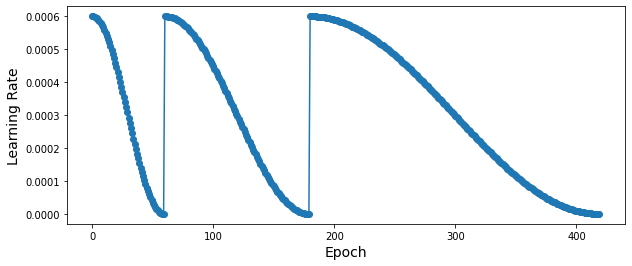

In [16]:
import math 
import matplotlib.pyplot as plt

LR_START = 1e-6
LR_MAX = 6e-4
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = 420
STEPS = [60,120,240]


def lrfn(epoch):
    if epoch<STEPS[0]:
        epoch2 = epoch
        EPOCHS2 = STEPS[0]
    elif epoch<STEPS[0]+STEPS[1]:
        epoch2 = epoch-STEPS[0]
        EPOCHS2 = STEPS[1]
    elif epoch<STEPS[0]+STEPS[1]+STEPS[2]:
        epoch2 = epoch-STEPS[0]-STEPS[1]
        EPOCHS2 = STEPS[2]
    
    if epoch2 < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch2 + LR_START
    elif epoch2 < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
          format(lr_y[0], max(lr_y), lr_y[-1]))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
plt.xlabel('Epoch',size=14)
plt.ylabel('Learning Rate',size=14)
plt.show()

# Train Model
Using one Nvidia V100 GPU with mixed precision, each epoch takes 60 seconds. Therefore 1 fold of 420 epochs takes 7 hours. Training 11 folds (LB 115) takes 77 GPU hours and training 32 folds (LB 112) takes 224 GPU hours. This model was trained offline using multiple GPUs. Each GPU trained one fold and we could train multiple folds in parallel in only 7 hours. This allowed us to train a submission in one evening.

In [17]:
EPOCH = EPOCHS
BATCH_SIZE = 64
NUM_FOLDS = 11
SEED = 42
VERBOSE = 1

with gpu_strategy.scope():
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
    
    test_preds = []
    oof_preds = []
    oof_true = []
    all_mask = []
    test_folds = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        test_folds.append(test_idx)
                
        checkpoint_filepath = f"folds{fold}_{VER}.hdf5"

        model = build_model()
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=opt, loss="mae", sample_weight_mode="temporal")

        sv = keras.callbacks.ModelCheckpoint(
                checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                save_weights_only=True, mode='auto', save_freq='epoch',
                options=None
        )
        if TRAIN_MODEL:
            history = model.fit(X_train, y_train, verbose=VERBOSE,
                                validation_data=(X_valid, y_valid, y_weight[test_idx,:,:1]), 
                                epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr_callback, sv], 
                                sample_weight=y_weight[train_idx,:,:1])
        else:
            model.load_weights(f'../input/vent-tranformer/folds{fold}_{VER}.hdf5')
       
        # PREDICT TEST
        print('Predicting Test...')
        test_preds.append(model.predict(test, batch_size=BATCH_SIZE, verbose=VERBOSE)[:,:,0]\
                          .squeeze().reshape(-1, 1).squeeze())
        
        # PREDICT OOF
        print('Predicting OOF...')
        oof_preds.append( model.predict(X_valid, verbose=VERBOSE)[:,:,0].squeeze().reshape(-1, 1) )
        oof_true.append( y_valid[:,:,0].squeeze().reshape(-1, 1) )
        score = mean_absolute_error(oof_true[-1], oof_preds[-1])
        print(f"Fold-{fold+1} | OOF all u_out Score: {score}")
        
        mask = np.where( X_valid[:,:,2].reshape((-1,1))==-1 )[0]
        mask_score = mean_absolute_error(oof_true[-1][mask], oof_preds[-1][mask])
        print(f"Fold-{fold+1} | OOF u_out=0 Score: {mask_score}")
        all_mask.append(mask)
        
        np.save(f'oof_v{VER}_trans',oof_preds)
        #np.save(f'oof_true_v{VER}_trans',oof_true)
        
        if FIRST_FOLD_ONLY: break

--------------- > Fold 1 < ---------------
Predicting Test...
786/786 [==============================] - 32s 38ms/step
Predicting OOF...
215/215 [==============================] - 6s 28ms/step
Fold-1 | OOF all u_out Score: 5.38969661201317
Fold-1 | OOF u_out=0 Score: 0.13299479509380943


# Plot Train Loss Valid Loss
Note that the loss display below (but this notebook version doesn't have plot) isn't just `pressure` MAE because it includes masked time steps and includes auxilliary targets `presssure.diff()` and `pressure.cumsum()`.

In [18]:
# PLOT TRAIN AND VAL HISTORY
if TRAIN_MODEL:
    plt.figure(figsize=(20,5))
    val = history.history['val_loss']
    trn = history.history['loss']
    plt.plot(np.arange(len(val)),trn,label='train loss')
    plt.plot(np.arange(len(val)),val,label='valid loss')
    plt.xlabel('Epoch',size=14)
    plt.ylabel('Loss',size=14)
    plt.title('Train and Valid Loss',size=16)
    plt.legend()
    plt.show()

# Display CV Score

In [19]:
if FIRST_FOLD_ONLY: 
    NUM_FOLDS=1

t = 0
for k in range(NUM_FOLDS):
    mask = all_mask[k]
    mae = np.mean(np.abs( oof_preds[k].flatten()[mask] - oof_true[k].reshape(-1, 1).squeeze()[mask] ))
    t += mae
    print('Fold',k,'has u_out MAE =',mae)
print('Overall CV MAE =',t/NUM_FOLDS)

Fold 0 has u_out MAE = 0.13299479509380943
Overall CV MAE = 0.13299479509380943


# Display CV Score with Post Process Rounding

In [20]:
t = 0
for k in range(NUM_FOLDS):
    oof = oof_preds[k].copy()
    oof2 = np.round( (oof+1.895744294564641)/0.07030214545121005 ) * 0.07030214545121005 -1.895744294564641
    mae = np.mean(np.abs( oof2.flatten()[mask] - oof_true[k].reshape(-1, 1).squeeze()[mask] ))
    t += mae
    print('Fold',k,'has u_out MAE with PP =',mae)
print('Overall CV MAE with PP =',t/NUM_FOLDS)

Fold 0 has u_out MAE with PP = 0.13071656108619467
Overall CV MAE with PP = 0.13071656108619467


# Save OOF DataFrame

In [21]:
train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')

# CREATE FOLDS
folds = test_folds.copy()
for k in range(len(folds)):
    folds[k] = np.ones_like(folds[k])*k
folds = np.hstack(folds)
folds = np.repeat(folds,80)

# CREATE LIST OF IDS USED DURING VALIDATION
test_folds = np.hstack(test_folds)
test_folds = 80 * np.repeat(test_folds,80)
shifter = np.tile( np.arange(80), len(test_folds)//80 )
test_folds += shifter

# SAVE OOF TO TRAIN DATAFRAME
train = train.loc[test_folds]
oof_preds = np.vstack(oof_preds)
oof_len = min(oof.shape)
train['oof'] = oof.squeeze()
train['fold'] = folds 

train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,oof,fold
2800,2801,42,50,20,0.000000,0.0,0,6.892024,6.643177,0
2801,2802,42,50,20,0.034739,0.0,0,6.048398,6.054459,0
2802,2803,42,50,20,0.069129,0.0,0,6.540513,6.420969,0
2803,2804,42,50,20,0.103087,0.0,0,6.470211,6.466551,0
2804,2805,42,50,20,0.137914,0.0,0,6.540513,6.519134,0


In [22]:
# SAVE OOF TO DISK
train.id = train.id.astype('int32')
train.oof = train.oof.astype('float32')
train.fold = train.fold.astype('int8')
train[['id','oof','fold']].to_csv(f'oof_v{VER}.csv')
train[['id','oof','fold']].head()

,id,oof,fold
2800,2801,6.643177,0
2801,2802,6.054459,0
2802,2803,6.420969,0
2803,2804,6.466551,0
2804,2805,6.519134,0


# Create Submission File

In [23]:
submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')
submission["pressure"] = sum(test_preds)/NUM_FOLDS
submission.to_csv(f'submission_mean_{VER}.csv', index=False)

In [24]:
submission["pressure"] = np.median(np.vstack(test_preds),axis=0)
submission.to_csv(f'submission_median_{VER}.csv', index=False)

In [25]:
submission.head()

,id,pressure
0,1,6.259286
1,2,5.921760
2,3,7.103161
3,4,7.561871
4,5,9.112475


In [26]:
submission.pressure =\
    np.round( (submission.pressure+1.895744294564641)/0.07030214545121005 ) * 0.07030214545121005 -1.895744294564641
submission.to_csv(f'submission_median_snap_{VER}.csv', index=False)

In [27]:
submission.head()

,id,pressure
0,1,6.259305
1,2,5.907794
2,3,7.102930
3,4,7.595045
4,5,9.141693
